# Investigate burst firing


## Imports

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

import pickle


In [3]:
from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [4]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)


## Load Original Data (Only Run Once)

In [ ]:
with open('data_bio482.pkl', 'rb') as file:
    data_df = pickle.load(file)

## Add AP Information (Only Run Once)

Using the Function_Detect_APs function, we can extract the details of the APs per sweep. For each entry in the original dataframe, we append the information about the APs in the Sweep_MembranePotential.

In [ ]:
def explain_ap(ap_params):
    return {
        'ap_thresh_vm': ap_params[1],
        'ap_peak_times': ap_params[2],
        'ap_peak_vm': ap_params[3],
        'ap_peak_amp': ap_params[4],
        'ap_duration': ap_params[5]
    }

In [ ]:
def process_sweep(row):
    """Process a single row to detect and explain action potentials."""
    sr_vm = row['Sweep_MembranePotential_SamplingRate']
    ap_vm_deriv_thresh = row['Cell_APThreshold_Slope']
    potential_across_time = row['Sweep_MembranePotential']

    # Detect action potentials
    ap_params = Function_Detect_APs(potential_across_time, sr_vm, ap_vm_deriv_thresh)

    # Return a dictionary of explained APs
    return {ap[0]: explain_ap(ap) for ap in ap_params}



In [ ]:
# Apply the function to each row
ap_info = data_df.apply(process_sweep, axis=1)


In [ ]:
ap_info

In [ ]:
data_df['ap_info'] = ap_info


In [ ]:
path = "/content/drive/MyDrive/NSCCM/"
file_to_save = "data_with_AP_info"
data_df.to_pickle(f'{path}{file_to_save}.pkl')

## Import New Pickle

No need to run last 2 sections if you already have data_with_AP_info.pkl file in your directory. It is too large to push to github.

In [5]:
with open('data_with_AP_info.pkl', 'rb') as file:
    data_df = pickle.load(file)

## Visualise Data:

In [6]:
data_df.head()

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes,ap_info
0,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.044009375, -0.044028125, -0.0439875, -0.04...",20000.0,"[[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...","[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]","{1.3559: {'ap_thresh_vm': -0.033646875, 'ap_pe..."
1,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.046275, -0.04629375, -0.046259375, -0.0462...",20000.0,"[[15.274999999999999, 15.375], [16.247, 16.643...","[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006...","{4.9021: {'ap_thresh_vm': -0.03423125, 'ap_pea..."
2,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.041896875, -0.0419125, -0.041909375, -0.04...",20000.0,"[[4.347000000000001, 7.0390000000000015], [8.2...","[[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]",2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]","{2.13865: {'ap_thresh_vm': -0.03129375, 'ap_pe..."
3,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.04655625, -0.0465875, -0.046575, -0.046596...",20000.0,nan,"[[0.002, 2.764], [12.03, 14.464], [14.814, 15....",2005.0,active touch,"[2.467493802679826, 2.459711310964792, 2.46562...",100.0,"[[2.766, 12.026], [15.626, 18.406], [18.814, 1...","{0.91115: {'ap_thresh_vm': -0.033, 'ap_peak_ti..."
4,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.047296875, -0.047284375, -0.047265625, -0....",20000.0,"[[4.411000000000001, 4.4809999999999945], [5.2...","[[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...",2005.0,active touch,"[2.4399999999999977, 2.4399999999999977, 2.440...",100.0,"[[5.228, 5.624], [7.462, 8.022], [11.002, 15.2...","{1.0954: {'ap_thresh_vm': -0.031940625, 'ap_pe..."


Each entry in the dataframe represents some sweep. There may be multiple sweeps per cell (as represented by Sweep_Counter) and so multiple entries with the same Cell_ID. Each entry has a Membrane Potential vs Time measure which can be visualised below:

In [7]:
def plot_aps(data_df, sweep_num, save_figure=False):

    sweep = data_df.iloc[sweep_num]

    sr_vm = sweep['Sweep_MembranePotential_SamplingRate']
    membrane_potential = sweep['Sweep_MembranePotential']
    
    time = [i/sr_vm for i in range(len(membrane_potential))]
    
    ap_peak_times = np.array([ap["ap_peak_times"] for ap in sweep["ap_info"].values()])
    ap_peak_vm = np.array([ap["ap_peak_vm"] for ap in sweep["ap_info"].values()])
    ap_thresh_vm = np.array([ap["ap_thresh_vm"] for ap in sweep["ap_info"].values()])
    ap_thresh_times = np.array([key for key in sweep["ap_info"].keys()])

    fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=150)
    
    ax.set_title(f'APs for Sweep {sweep_num}')
    ax.plot(time, membrane_potential, lw=0.5,  zorder=0)
    ax.scatter(ap_peak_times, ap_peak_vm, lw=0.5, marker='+', color='r')
    ax.scatter(ap_thresh_times, ap_thresh_vm, lw=0.1, marker='o', color='b')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Vm (V)')
    plt.xlim(6,6.5)
    
    if save_figure:
        # Save figure
        fname = os.path.join('images', f'Example_Cell_{sweep_num}.png')
        plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')


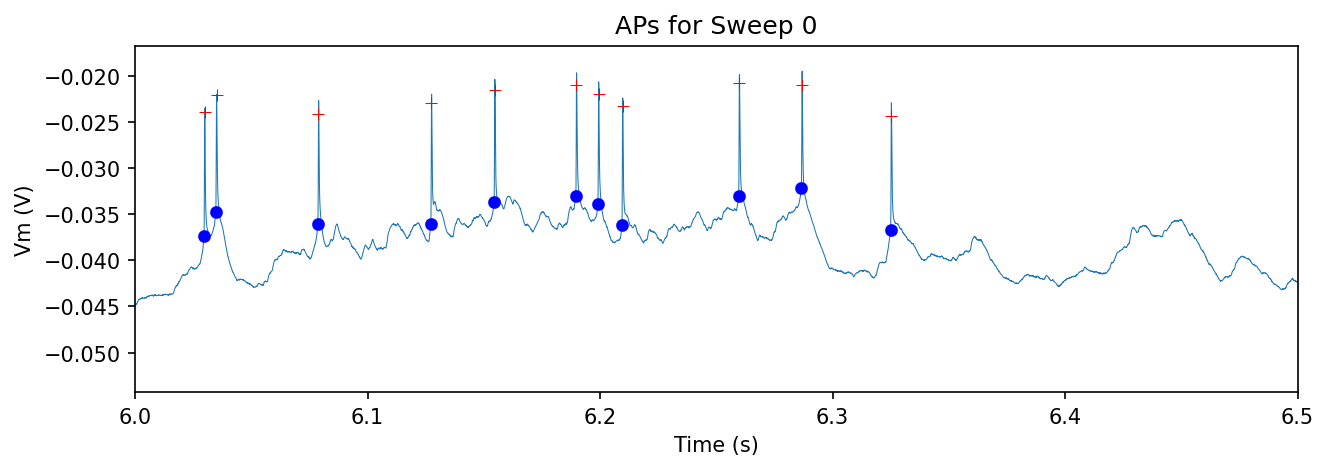

In [8]:
plot_aps(data_df, 0, save_figure = True)

## Identify Bursts for one sweep 

In [27]:
ap_df = pd.DataFrame.from_dict(data_df.ap_info[0], orient='index')

In [29]:
ap_df['peak_end_time'] = ap_df.index + ap_df['ap_duration'] / 1000
ap_df['time_since_last_AP'] = ap_df.index - ap_df['peak_end_time'].shift(1) 
ap_df['time_since_last_AP_2x'] = ap_df.index - ap_df['peak_end_time'].shift(2) 
ap_df['is_in_burst'] = ap_df['time_since_last_AP_2x'] < .03 
ap_df['is_in_burst'] = ap_df['is_in_burst'] | ap_df['is_in_burst'].shift(-1) | ap_df['is_in_burst'].shift(-2)

In [32]:
ap_df.head()

,ap_thresh_vm,ap_peak_times,ap_peak_vm,ap_peak_amp,ap_duration,peak_end_time,time_since_last_AP,time_since_last_AP_2x,is_in_burst
1.35590,-0.033647,1.3562,-0.021266,0.012381,0.35,1.35625,NaN,NaN,False
2.99410,-0.037781,2.9944,-0.024581,0.013200,0.35,2.99445,1.63785,NaN,False
4.57150,-0.043684,4.5718,-0.030378,0.013306,0.45,4.57195,1.57705,3.21525,False
4.70110,-0.034181,4.7014,-0.021247,0.012934,0.40,4.70150,0.12915,1.70665,False
4.78105,-0.034022,4.7813,-0.022019,0.012003,0.40,4.78145,0.07955,0.20910,False


In [33]:
def burst_times(ap_df):
    bursts = []
    i = 0
    while i < len(ap_df):
        row = ap_df.iloc[i]
        is_in_burst = row['is_in_burst']
        if is_in_burst:
            burst_start = row.name
            for j in range(i, len(ap_df)):
                row_1 = ap_df.iloc[j]
                if j == len(ap_df)-1:
                    # we have reached last peak in sweep
                    burst_end = row_1['peak_end_time']
                    bursts.append((burst_start, burst_end, j-i+1))
                    break
                row_2 = ap_df.iloc[j+1]
                if not row_2['is_in_burst']:
                    # we have reached peak which is not in this burst
                    burst_end = row_1['peak_end_time']
                    bursts.append((burst_start, burst_end, j-i+1))
                    break
                else:
                    continue
            i = j
        i += 1
    return bursts

In [34]:
burst_times(ap_df)

[(6.18955, 6.209849999999999, 3)]

## Bursts for all sweeps

In [71]:
burst_times_per_sweep = []

for i in range(len(data_df)):
    if i % 10 == 0:
        print(f"completing sweep {i+1}")
    ap_df = pd.DataFrame.from_dict(data_df.ap_info[i], orient='index')
    if len(ap_df):
        ap_df['peak_end_time'] = ap_df.index + ap_df['ap_duration'] / 1000
        ap_df['time_since_last_AP'] = ap_df.index - ap_df['peak_end_time'].shift(1) 
        ap_df['time_since_last_AP_2x'] = ap_df.index - ap_df['peak_end_time'].shift(2) 
        ap_df['is_final_in_burst'] = ap_df['time_since_last_AP_2x'] < .03 
        ap_df['is_in_burst'] = ap_df['is_final_in_burst'] | ap_df['is_final_in_burst'].shift(-1) | ap_df['is_final_in_burst'].shift(-2)
        burst_info = burst_times(ap_df)
        burst_times_per_sweep.append(burst_info)
        print(f"found {len(burst_info)} bursts")
    else:
        print(f"found no peaks")
        burst_times_per_sweep.append([])
    

completing sweep 1
found 1 bursts
found 4 bursts
found 5 bursts
found 27 bursts
found 6 bursts
found 4 bursts
found 4 bursts
found 0 bursts
found 0 bursts
found no peaks
completing sweep 11
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 3 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
completing sweep 21
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 1 bursts
found 4 bursts
completing sweep 31
found 3 bursts
found no peaks
found no peaks
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 0 bursts
found 1 bursts
completing sweep 41
found 0 bursts
found 2 bursts
found 0 bursts
found 0 bursts
found no peaks
found 0 bursts
found no peaks
found no peaks
found 0 bursts
found 0 bursts
completing sweep 51
found 0 bursts
found 2 bursts
found 1 bursts
found 4 bursts
found 3 bursts
found no peaks
found 0 bursts
found 0 bursts
found no p

In [73]:
file_path = "data_with_burst_info.txt"

# Write the list to a text file
with open(file_path, "w") as file:
    for item in burst_times_per_sweep:
        file.write(f"{item}\n")

In [67]:
data_df.head()

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes,ap_info
0,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.044009375, -0.044028125, -0.0439875, -0.04...",20000.0,"[[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...","[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]","{1.3559: {'ap_thresh_vm': -0.033646875, 'ap_pe..."
1,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.046275, -0.04629375, -0.046259375, -0.0462...",20000.0,"[[15.274999999999999, 15.375], [16.247, 16.643...","[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006...","{4.9021: {'ap_thresh_vm': -0.03423125, 'ap_pea..."
2,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.041896875, -0.0419125, -0.041909375, -0.04...",20000.0,"[[4.347000000000001, 7.0390000000000015], [8.2...","[[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]",2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]","{2.13865: {'ap_thresh_vm': -0.03129375, 'ap_pe..."
3,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.04655625, -0.0465875, -0.046575, -0.046596...",20000.0,nan,"[[0.002, 2.764], [12.03, 14.464], [14.814, 15....",2005.0,active touch,"[2.467493802679826, 2.459711310964792, 2.46562...",100.0,"[[2.766, 12.026], [15.626, 18.406], [18.814, 1...","{0.91115: {'ap_thresh_vm': -0.033, 'ap_peak_ti..."
4,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.047296875, -0.047284375, -0.047265625, -0....",20000.0,"[[4.411000000000001, 4.4809999999999945], [5.2...","[[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...",2005.0,active touch,"[2.4399999999999977, 2.4399999999999977, 2.440...",100.0,"[[5.228, 5.624], [7.462, 8.022], [11.002, 15.2...","{1.0954: {'ap_thresh_vm': -0.031940625, 'ap_pe..."


In [72]:
len(burst_times_per_sweep)

831